## Learnability 

In [1]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp

import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
from copy import copy
from importlib import reload

from tools import learnabilityHelpers as lh

## this suppresses the warnings encountered during normal use of Matthew's Corr Coeff from sklearn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
lh.generate_kinase_labels()

Let's generate a few go_annotation datasets. 

We'll use the original annotations (post-stopwords) binarized, a single-occurence-filtered-out annotations binarized, and a single-occurence-filtered-out tfidf model.

In [3]:
go_file = '../data/GeneOntology/kinase_go_processes.csv'
go_dir = './'

# create a dictionary with our datasets
go_data_dict, go_transform_dict = lh.get_go_data_dict(go_file=go_file)

In [4]:
for k in go_data_dict.keys():
    print(k, ': size: ', go_data_dict[k].iloc[5].shape)

go : size:  (2867,)
freq : size:  (1380,)
tfidf : size:  (1381,)


Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

In [5]:
cluster_dir = '../results/networkClusters/'

spinglass_file = 'consensus_spinglass.txt'
spinglass_data_dict = {key:lh.add_cluster_labels(cluster_dir+spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fastgreedy_file = 'fastgreedy_clusters.txt'
fastgreedy_data_dict = {key:lh.add_cluster_labels(cluster_dir+fastgreedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensus_eigenvector.txt'
eigen_data_dict = {key:lh.add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

labelprop_file = 'consensus_label_propagation.txt'
labelprop_dict = {key:lh.add_cluster_labels(cluster_dir+labelprop_file,
                                  val) for key, val in go_data_dict.items()}

walktrap_file = 'consensus_walktrap.txt'
walktrap_dict = {key:lh.add_cluster_labels(cluster_dir+walktrap_file,
                                  val) for key, val in go_data_dict.items()}

louvain_super_file = 'louvain_clusters.txt'
louvain_super_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_super_file,
                                  val) for key, val in go_data_dict.items()}

louvain_sub_file = 'louvain_small_clusters.txt'
louvain_sub_dict = {key:lh.add_cluster_labels(cluster_dir+louvain_sub_file,
                                  val) for key, val in go_data_dict.items()}

infomap_file = 'consensus_infomap.txt'
infomap_dict = {key:lh.add_cluster_labels(cluster_dir+infomap_file,
                                  val) for key, val in go_data_dict.items()}

edge_betweenness_file = 'edge_betweenness_community_clusters.txt'
edge_betweenness_dict = {key:lh.add_cluster_labels(cluster_dir+edge_betweenness_file,
                                  val) for key, val in go_data_dict.items()}

method_list = ['spinglass', 'fastgreedy', 'eigen', 'labelprop', 'walktrap', 'louvain_super', 'louvain_sub', 'infomap', 'edge_between']
method_dicts = [spinglass_data_dict, fastgreedy_data_dict, eigen_data_dict, labelprop_dict, walktrap_dict, louvain_super_dict, louvain_sub_dict, infomap_dict, edge_betweenness_dict]
composite_data_dict = {x:y for x,y in zip(method_list, method_dicts)}

Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  5 kinases due to zero length post-processing
Dropped  36 kinases due to zero length post-processing
Dropped  0 kinases due

Now, let's import a few linear classifiers

In [6]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear', class_weight='balanced')
cnb = CNB()

classifiers = [svm, cnb]
clf_names = [str(clf.__class__).split('.')[-1][0:-2] for clf in classifiers]

And get the accuracy and MCC scores for our datasets

In [7]:
validation_kwargs = {'n_run':100, 'metrics':['accuracy', 'matthews', 'prf'], 'parallel':max(1, mp.cpu_count()-1), 'test_size':0.3}
results_dict = {}

for method in composite_data_dict.keys():
    results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:lh.validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in composite_data_dict[method].items() for clf in classifiers}

# break the class-wise precision, recall, and f-score results off
prf_results = {}
for method in composite_data_dict.keys():
    prf_results[method] = {}
    for key in results_dict[method].keys():
        # convert the multiple scores to lists
        results_dict[method][key] = list(zip(*results_dict[method][key]))
        
        # pop the last item in the list, the prf score
        prf_results[method][key] = results_dict[method][key].pop(-1)    


### Average the accuracy and MCC scores and computer the standard deviation

In [8]:
mean_results = {}
std_results = {}

for method in method_list:
    mean_results[method] = {key:[np.mean(np.array(score_arr)) for score_arr in results_dict[method][key]] for key in results_dict[method].keys()}
    std_results[method] = {key:[np.std(np.array(score_arr)) for score_arr in results_dict[method][key]] for key in results_dict[method].keys()}
    
print('Accuracy, MCC')
for method in method_list:
    print(method+' | '+str(mean_results[method]['SVC']))
        
print('\nAcc Std, MCC Std')    
for method in method_list:
    print(method+' | '+str(std_results[method]['SVC']))

Accuracy, MCC
spinglass | [0.2788275862068965, 0.25959973211498566]
fastgreedy | [0.6371724137931034, 0.5486639306776567]
eigen | [0.531655172413793, 0.3862110126447697]
labelprop | [0.9933103448275861, 0.7707586673693063]
walktrap | [0.6259310344827586, 0.265719937961755]
louvain_super | [0.6542758620689655, 0.59163447631229]
louvain_sub | [0.5787586206896551, 0.5359078055385956]
infomap | [0.4609655172413793, 0.35353386770434736]
edge_between | [0.16868965517241377, 0.10748823842299961]

Acc Std, MCC Std
spinglass | [0.07356558545042305, 0.06154963153596983]
fastgreedy | [0.0336717737460578, 0.041671637061368734]
eigen | [0.03774997539194889, 0.048658290154573826]
labelprop | [0.005556327070223296, 0.2538352807546738]
walktrap | [0.07048073416351662, 0.07382133400275351]
louvain_super | [0.03348423236218297, 0.03867453159993898]
louvain_sub | [0.048772616632438245, 0.0443123393496151]
infomap | [0.14961455034252982, 0.07015639660059124]
edge_between | [0.09576238925692594, 0.04855912

In [9]:
mod_table = pd.read_csv('../results/networkClusters/clustering_modularity_results.txt', sep='\t')
mod_table

,fast_greedy,spinglass,eigen,walktrap,label,louvain,small_louvain,infomap,edge_between
0,0.279008,0.26696,0.229506,0.06015,0.005479,0.314593,0.300422,0.174903,0.16289


In [10]:
cluster_descriptions = {}
mod_scores = {}

mod_scores = {x:y for x,y in zip(method_list, mod_table.loc[0].values)}

for method in method_list:
    # grab the cluster list from one of the datatype dictionaries
    cluster_list = composite_data_dict[method]['go']['cluster']
    
    # create a counter to get the count data
    clust_counter = Counter(cluster_list)
    
    # count and number of cluster data
    cluster_counts = list(clust_counter.values())
    n_clust = len(cluster_counts)
    
    # mean and std of cluster size
    size_mean = np.round(np.mean(cluster_counts), 1)
    size_std = np.round(np.std(cluster_counts), 1)
    
    # largest and smallest cluster size
    size_max = np.max(cluster_counts) 
    
    # update size and modularity data
    cluster_descriptions[method] = {'N_clust':n_clust, 'Mean clust size':size_mean, 'Clust size std.':size_std, 'Largest clust size':size_max}
    cluster_descriptions[method].update({'Modularity':np.round(mod_scores[method],4)})
    
    # update learnability
    # clf-specific results
    #cluster_descriptions[method].update({clf_name+' accuracy':np.round(mean_results[method][clf_name],2)[0] for clf_name in clf_names})
    #cluster_descriptions[method].update({clf_name+' MCC':np.round(mean_results[method][clf_name],2)[1] for clf_name in clf_names})
    # composite results
    cluster_descriptions[method].update({'Composite Accuracy':np.round(np.mean([mean_results[method][clf_name][0] for clf_name in clf_names]),4)})
    cluster_descriptions[method].update({'Comp Acc std.':np.round(np.mean([std_results[method][clf_name][0] for clf_name in clf_names]),4)})
    cluster_descriptions[method].update({'Composite MCC':np.round(np.mean([mean_results[method][clf_name][1] for clf_name in clf_names]),4)})
    cluster_descriptions[method].update({'Comp MCC std.':np.round(np.mean([std_results[method][clf_name][1] for clf_name in clf_names]),4)})
    
results_df = pd.DataFrame.from_dict(cluster_descriptions, orient='index').sort_values(by='Composite MCC', ascending=False)

results_df.columns = ['No. Clusters', 'Mean size', 'sigma size', 'Largest clust',
       'Mod', 'Comp Acc', 'sigma Comp Acc', 'Comp MCC',
       'sigma Comp MCC']

display(results_df)

,No. Clusters,Mean size,sigma size,Largest clust,Mod,Comp Acc,sigma Comp Acc,Comp MCC,sigma Comp MCC
louvain_super,9,57.4,35.8,142,0.3146,0.6489,0.0355,0.5877,0.0408
fastgreedy,10,51.7,50.7,133,0.2670,0.6386,0.0325,0.5548,0.0398
louvain_sub,26,19.9,27.9,123,0.3004,0.5919,0.0429,0.5465,0.0419
labelprop,4,129.2,217.5,506,0.0602,0.8539,0.0196,0.4895,0.1622
infomap,52,9.9,33.1,240,0.1749,0.5342,0.0956,0.4205,0.0618
eigen,5,103.4,43.8,185,0.2295,0.5293,0.0365,0.3893,0.0466
spinglass,77,6.7,17.0,118,0.2790,0.4208,0.0536,0.3880,0.0489
walktrap,12,43.1,94.2,331,0.0055,0.5724,0.0534,0.2369,0.0640
edge_between,205,2.5,11.3,143,0.1629,0.2726,0.0624,0.1989,0.0400


We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


## Convert pandas.DataFrame to TeX


In [22]:
tex_string = results_df.to_latex()
with open('../results/tables/super_table.tex', 'w') as f:
    f.write(tex_string)
print(tex_string)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  No. Clusters &  Mean size &  sigma size &  Largest clust &     Mod &  Comp Acc &  sigma Comp Acc &  Comp MCC &  sigma Comp MCC \\
\midrule
louvain\_super &             9 &       57.4 &        35.8 &            142 &  0.3146 &    0.6489 &          0.0355 &    0.5877 &          0.0408 \\
fastgreedy    &            10 &       51.7 &        50.7 &            133 &  0.2670 &    0.6386 &          0.0325 &    0.5548 &          0.0398 \\
louvain\_sub   &            26 &       19.9 &        27.9 &            123 &  0.3004 &    0.5919 &          0.0429 &    0.5465 &          0.0419 \\
labelprop     &             4 &      129.2 &       217.5 &            506 &  0.0602 &    0.8539 &          0.0196 &    0.4895 &          0.1622 \\
infomap       &            52 &        9.9 &        33.1 &            240 &  0.1749 &    0.5342 &          0.0956 &    0.4205 &          0.0618 \\
eigen         &             5 &      103.4 &        43.8 &            185 &  0.22

## Generate Intra-Supercluster Analysis of Louvain Subclusters


In [23]:
louvain_combined_dict = {key:louvain_super_dict[key].drop('GO Labels', axis=1).merge(louvain_sub_dict[key], on='names', how='left', suffixes = ['_super', '_sub'])
                         for key, val in go_data_dict.items()}


In [24]:
# this is a map of the subclusters in each supercluster
super_sub_dict = louvain_combined_dict['go'].groupby('cluster_super')['cluster_sub'].agg(set)
display(super_sub_dict)

cluster_super
1                            {8, 21, 7}
2                            {24, 9, 2}
3                                  {11}
4                           {16, 1, 19}
5                              {13, 15}
6    {4, 6, 10, 14, 17, 18, 22, 23, 25}
7                                   {3}
8                           {20, 12, 5}
9                                  {26}
Name: cluster_sub, dtype: object

In [25]:
validation_kwargs = {'n_run':100, 'metrics':['accuracy', 'matthews'], 'parallel':max(mp.cpu_count()-1, 1), 'test_size':0.3}
intra_results_dict = {}

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            intra_results_dict[sup_] = {str(clf.__class__).split('.')[-1][0:-2]:lh.validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf in classifiers}


In [18]:
Counter(louvain_combined_dict['go'][louvain_combined_dict['go']['cluster_super']==4].cluster_sub).items()

dict_items([(1, 52), (16, 3), (19, 3)])

In [19]:
validation_kwargs = {'n_run':100, 'metrics':['confusion'], 'parallel':max(mp.cpu_count()-1, 1), 'test_size':0.3}
conf_intra_results_dict = {}

# add linear unbalanced svc to the classifiers for visualization
classifiers_ext = {str(clf.__class__).split('.')[-1][0:-2]:clf for clf in classifiers}
unbal_svm = SVC(kernel='linear')
classifiers_ext['unbalSVM'] = unbal_svm 

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        conf_intra_results_dict[sup_] = {clf_key:lh.validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf_key, clf in classifiers_ext.items()}


In [20]:
## normalize the heatmap by row
for sup_ in conf_intra_results_dict.keys():
    for learning_algo in conf_intra_results_dict[sup_].keys():
        # aggregate into average confusion matrix -- not integral do to random sampling size differences
        composite_score = np.mean(conf_intra_results_dict[sup_][learning_algo], axis=0)
        row_sums = np.sum(composite_score, axis=1)
        # normalize
        for i in range(composite_score.shape[0]):
            # add 1 for stability
            composite_score[i,:] = composite_score[i,:] / (1 if row_sums[i] == 0 else row_sums[i])
            
        conf_intra_results_dict[sup_][learning_algo] = composite_score

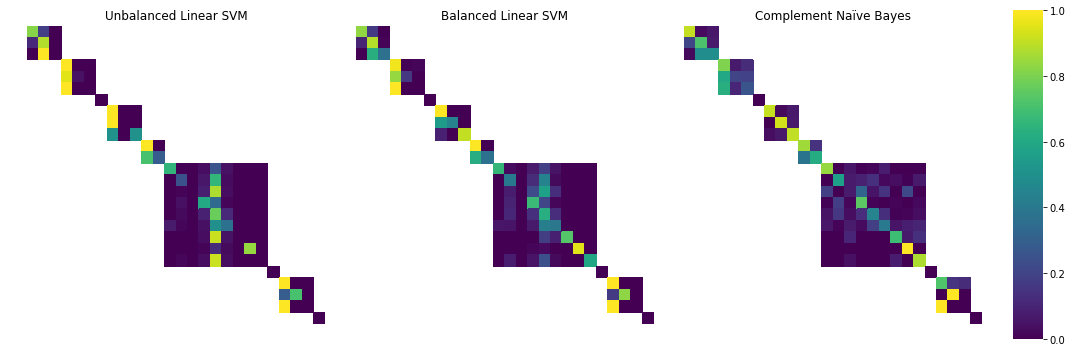

In [27]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5), gridspec_kw={'width_ratios':[10,10,10,1]})
for ax in axes[:3]:
    ax.axis('off')

## put complementNB on the right    
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=True, ax=axes[2], cbar_ax=axes[3])


## put balanced SVC in the middle
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['SVC']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[1])

### put unbalanced svc on the left
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['unbalSVM']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[0])


## layout and titles
plt.tight_layout()
axes[0].set_title('Unbalanced Linear SVM')
axes[1].set_title('Balanced Linear SVM')
axes[2].set_title('Complement Naïve Bayes')

plt.savefig('../results/images/intracluster_learnability_comparison.pdf')
#plt.savefig('../viz/images/png/intracluster_learnability_comparison.png')

plt.show()

## Generate Learnability Characterizations

In [28]:
louv_X, __, louv_y, __ = lh.get_tts(dat=louvain_super_dict['freq'],test_size=0)

In [29]:
louv_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_super_characterizers:
    clf.fit(louv_X, louv_y)

In [30]:
def f_importances(coef, names, top=5, bot=None, plot=True, ax = None):
    ''' returns the most important top (positive) and bot (negative) features
    
    '''
    if bot is None:
        bot = top
    
    importances = coef
    
    # puts smallest first
    importances,names = zip(*sorted(zip(importances,names)))
    # smallest is still first
    most_negative_importances = importances[0:bot]
    most_negative_names = names[0:bot]
    
    most_positive_importances = importances[-top:]
    most_positive_names = names[-top:]
    
    
    if plot:
        if ax is None:
            plt.yticks(range(bot+top), most_negative_names+most_positive_names)
            plt.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            plt.barh(range(bot), most_negative_importances, align='center', color='blue')
            plt.show()
        else:
            ax.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            ax.barh(range(bot), most_negative_importances, align='center', color='blue')
            ax.set_yticks(range(bot+top))
            ax.set_yticklabels(most_negative_names+most_positive_names)
    else:
        return most_negative_names, most_negative_importances, most_positive_importances, most_positive_names
        

(n_samples, n_classes * (n_classes - 1) / 2)

In [31]:
feat = go_transform_dict['freq'].classes_

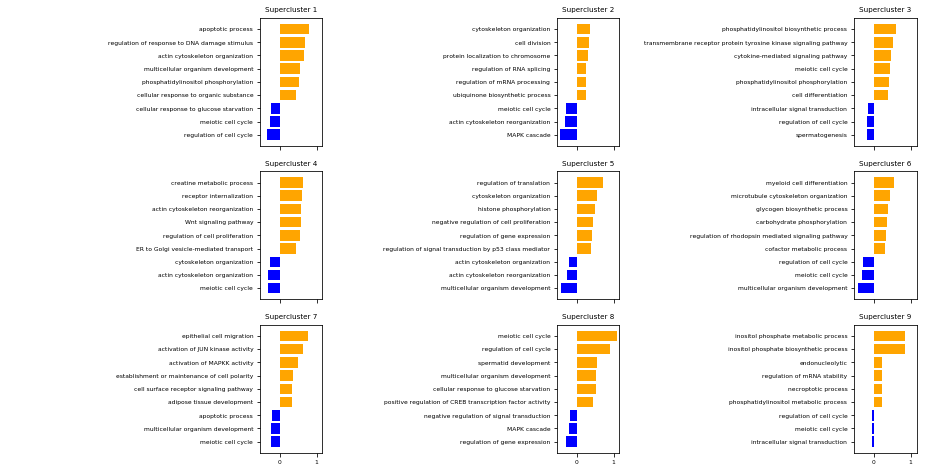

In [32]:
%matplotlib inline
plt.rc('font', **{'family':'normal', 'size':6})    
fig, axes = plt.subplots(ncols=4, nrows=3, figsize= (16,8), sharex=True, gridspec_kw={'width_ratios':[.5,20,20,20]})
plt.subplots_adjust(wspace=5.)
#plt.tight_layout()

for i in range(3):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.mean(lh.get_svm_coeffs_for_cluster(louv_super_characterizers[0], idx), axis=0), names=feat, ax=axes[idx // 3][idx % 3+1], top=6, bot=3)
    axes[idx // 3][idx % 3+1].set_title('Supercluster '+str(sup_))


plt.savefig('../results/images/supercluster_characterization_GO_mean.pdf')    
#plt.savefig('../viz/images/png/supercluster_characterization_GO_mean.png')    
plt.show()
#plt.show()


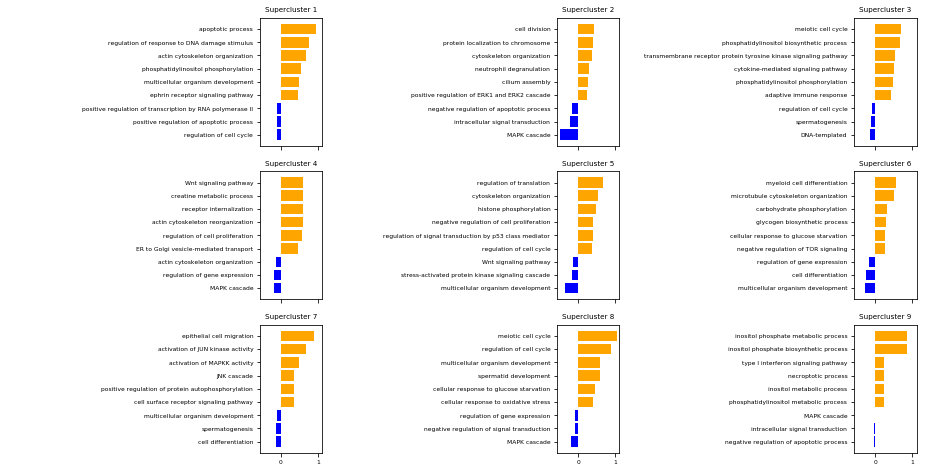

In [33]:
%matplotlib inline
plt.rc('font', **{'family':'normal', 'size':6})    
fig, axes = plt.subplots(ncols=4, nrows=3, figsize= (16,8), sharex=True, gridspec_kw={'width_ratios':[.5,20,20,20]})
plt.subplots_adjust(wspace=5.)
#plt.tight_layout()

for i in range(3):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.median(lh.get_svm_coeffs_for_cluster(louv_super_characterizers[0], idx), axis=0), names=feat, ax=axes[idx // 3][idx % 3+1], top=6, bot=3)
    axes[idx // 3][idx % 3+1].set_title('Supercluster '+str(sup_))


plt.savefig('../results/images/supercluster_characterization_GO_median.pdf')   
#plt.savefig('../viz/images/png/supercluster_characterization_GO_median.png')   
plt.show()
#plt.show()


### Understudied Inclusion

In [40]:
understudied = set(pd.read_csv('../data/miscReference/dark_kinases.csv').symbol.tolist())

louv = pd.read_csv('../results/networkClusters/louvain_clusters.txt', sep='\t', index_col=0)
louv.columns = ['cluster_super']
louv['cluster_sub'] = pd.read_csv('../results/networkClusters/louvain_small_clusters.txt', sep='\t', index_col=0)['cluster']
louv['understudied'] = pd.Series(louv.index).apply(lambda x: x in understudied).tolist()

louv.head()

,cluster_super,cluster_sub,understudied
names,,,
MST1R,3,11,False
YES1,3,11,False
TYRO3,3,11,False
FGR,3,11,False
SRC,3,11,False


In [41]:
sub_super_dict = louv.groupby('cluster_sub')['cluster_super'].agg('mean').to_dict()
sub_super_dict

{1: 4,
 2: 2,
 3: 7,
 4: 6,
 5: 8,
 6: 6,
 7: 1,
 8: 1,
 9: 2,
 10: 6,
 11: 3,
 12: 8,
 13: 5,
 14: 6,
 15: 5,
 16: 4,
 17: 6,
 18: 6,
 19: 4,
 20: 8,
 21: 1,
 22: 6,
 23: 6,
 24: 2,
 25: 6,
 26: 9}

In [45]:
super_under_map = (louv.groupby('cluster_super')['understudied'].agg(sum)/louv.groupby('cluster_super')['understudied'].agg(len)).to_dict()
sub_under_map = (louv.groupby('cluster_sub')['understudied'].agg(sum)/louv.groupby('cluster_sub')['understudied'].agg(len)).to_dict()

louv['super_prop_under'] = louv.cluster_super.apply(super_under_map.get)
louv['sub_prop_under'] = louv.cluster_sub.apply(sub_under_map.get)

louv.head()

,cluster_super,cluster_sub,understudied,super_prop_under,sub_prop_under
names,,,,,
MST1R,3,11,False,0.12,0.12
YES1,3,11,False,0.12,0.12
TYRO3,3,11,False,0.12,0.12
FGR,3,11,False,0.12,0.12
SRC,3,11,False,0.12,0.12


In [43]:
agg_dict = {'understudied':len}
agg_dict.update({x:np.mean for x in ['super_prop_under','sub_prop_under']})

understudied_table = louv.groupby(['cluster_super', 'cluster_sub']).agg(agg_dict)
understudied_table['super_prop_under'] = understudied_table['super_prop_under'].apply(lambda x: np.round(x*100,2))
understudied_table['sub_prop_under'] = understudied_table['sub_prop_under'].apply(lambda x: np.round(x*100,2))

raw_columns = ['Subclust\nSize', 'Superclust\n% Understud', 'Subclust\n% Understud']
multindex_column_tuples = [tuple(col.split('\n')) for col in raw_columns]

understudied_table.columns = pd.MultiIndex.from_tuples(multindex_column_tuples)

for col in understudied_table.columns:
    understudied_table[col] = understudied_table[col].apply(lambda x: np.round(x, 2))
understudied_table


Subclust  Superclust    Subclust
                              Size % Understud % Understud
cluster_super cluster_sub                                 
1             7                 17       22.50        0.00
              8                 19       22.50       36.84
              21                 4       22.50       50.00
2             2                123       43.66       43.09
              9                 14       43.66       42.86
              24                 5       43.66       60.00
3             11                75       12.00       12.00
4             1                 52       17.24       13.46
              16                 3       17.24        0.00
              19                 3       17.24      100.00
5             13                31       15.00       12.90
              15                 9       15.00       22.22
6             4                  9       25.00       22.22
              6                  8       25.00       12.50
              10                 3       25.00        0.00
              14                12       25.00       33.33
              17                15       25.00       33.33
              18                 9       25.00       44.44
              22                 2       25.00        0.00
              23                 4       25.00        0.00
              25                 2       25.00        0.00
7             3                 63       14.29       14.29
8             5                 21       28.57       19.05
              12                 5       28.57       40.00
              20                 2       28.57      100.00
9             26                 7       14.29       14.29

### Generate GO Slim whitelist

In [47]:
paf = pd.read_csv('../data/GeneOntology/PAF.txt', sep='\t')
display(paf.shape)
paf.head()

(6045, 17)

,PRO_ID,Object_term,Object_syny,Modifier,Relation,Ontology_ID,Ontology_term,Relative_to,Interaction_with,Evidence_source,Evidence_code,Taxon,Inferred_from,DB_ID,Date,Assigned_by,Comment
0,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,has_part,Pfam:PF01466,"Skp1 family, dimerisation domain",NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
1,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,has_part,Pfam:PF03931,"Skp1 family, tetramerisation domain",NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
2,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,part_of,GO:0019005,SCF ubiquitin ligase complex,NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
3,PR:000000002,E3 ubiquitin ligase SFC complex Skp1 subunit,NaN,NaN,participates_in,GO:0006511,ubiquitin-dependent protein catabolic process,NaN,NaN,PIRSF:PIRSF028729,ISS,NaN,PIRSF:PIRSF028729,PIRSF:PIRSF028729,20080301,PRO:CNA,NaN
4,PR:000000003,HLH DNA-binding protein inhibitor,bHLH clade D|bHLH class V|DNA-binding protein ...,NaN,has_function,GO:0003700,DNA-binding transcription factor activity,NaN,NaN,PIRSF:PIRSF005808,ISS,NaN,PIRSF:PIRSF005808,PIRSF:PIRSF005808,20150820,PRO:CNA,NaN


In [49]:
paf[paf['Ontology_ID'].apply(lambda x: 'GO:' in x)][['Ontology_ID', 'Ontology_term']].set_index('Ontology_ID').to_csv('../data/GeneOntology/go_subset.csv', sep='\t', header=False)

In [54]:
# make go subset data
lh.generate_kinase_labels(use_go_subset=True, out_path='../data/GeneOntology/kinase_go_slim_processes.csv')

In [55]:
go_slim_data_dict, go_slim_transform_dict = lh.get_go_data_dict(go_file='../data/GeneOntology/kinase_go_slim_processes.csv')

In [56]:
go_slim_data_dict['freq'].iloc[1].shape

(247,)

In [57]:
missing = list(set(go_slim_data_dict['go'].index) - set(go_slim_data_dict['freq'].index))

missing_df = pd.DataFrame([[[0]*len(go_slim_data_dict['freq'].iloc[0])]], index=missing)
go_slim_data_dict['freq'] = go_slim_data_dict['freq'].append(missing_df)
#missing_df

In [63]:
slim_test = pd.DataFrame(go_slim_data_dict['freq'])
#slim_test = pd.DataFrame(go_slim_data_dict['freq'])
#slim_test.columns = ['GO Labels']
#slim_test['cluster'] = louv.cluster_super.tolist()
slim_test.head()

,GO Labels,cluster
MAP3K20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
PKM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
CDK15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
ARAF,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
HIPK1,"[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


In [64]:
louv_X, __, louv_y, __ = lh.get_tts(dat=slim_test,test_size=0)
louv_slim_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_slim_super_characterizers:
    clf.fit(louv_X, louv_y)
    
slim_feat = list(go_slim_transform_dict['freq'].classes_)#.to_list()
slim_feat[:10]

['BMP signaling pathway',
 'DNA damage induced protein phosphorylation',
 'DNA repair',
 'DNA-templated',
 'ERK1 and ERK2 cascade',
 'Fc-epsilon receptor signaling pathway',
 'MAPK cascade',
 'Mullerian duct regression',
 'MyD88-dependent toll-like receptor signaling pathway',
 'MyD88-independent toll-like receptor signaling pathway']

In [66]:
# fix long slim feats
for i in range(len(slim_feat)):
    if len(slim_feat[i]) < 50:
        continue
    else:
        num_spaces = len(slim_feat[i].split(' '))
        slim_feat[i] = ' '.join(slim_feat[i].split(' ')[:num_spaces//2+1])+'...'
        
slim_feat[:10]

['BMP signaling pathway',
 'DNA damage induced protein phosphorylation',
 'DNA repair',
 'DNA-templated',
 'ERK1 and ERK2 cascade',
 'Fc-epsilon receptor signaling pathway',
 'MAPK cascade',
 'Mullerian duct regression',
 'MyD88-dependent toll-like receptor...',
 'MyD88-independent toll-like receptor...']

In [67]:
louv_slim_super_characterizers[0].score(louv_X, louv_y)

0.6692456479690522

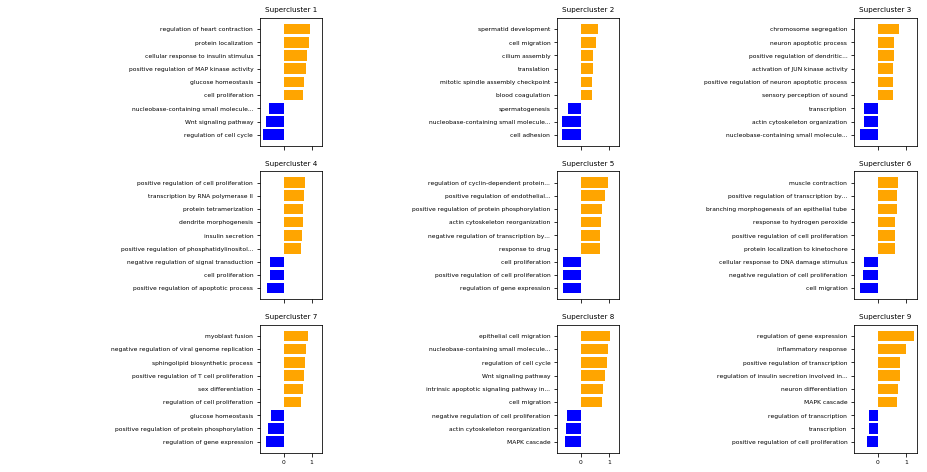

In [68]:
%matplotlib inline
plt.rc('font', **{'family':'normal', 'size':6})    
fig, axes = plt.subplots(ncols=4, nrows=3, figsize= (16,8), sharex=True, gridspec_kw={'width_ratios':[.5,20,20,20]})
plt.subplots_adjust(wspace=5.)

for i in range(3):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.mean(lh.get_svm_coeffs_for_cluster(louv_slim_super_characterizers[0], idx), axis=0), names=slim_feat, ax=axes[idx // 3][idx % 3+1], top=6, bot=3)
    axes[idx // 3][idx % 3+1].set_title('Supercluster '+str(sup_))

    
plt.savefig('../results/images/supercluster_characterization_PIR_PAF_SLIM_GO_mean.pdf')
#plt.savefig('../viz/images/png/supercluster_characterization_PIR_PAF_SLIM_GO_mean.png')
plt.show()

In [69]:
super_under_map

{1: 0.225,
 2: 0.43661971830985913,
 3: 0.12,
 4: 0.1724137931034483,
 5: 0.15,
 6: 0.25,
 7: 0.14285714285714285,
 8: 0.2857142857142857,
 9: 0.14285714285714285}

In [70]:
# super_sub_dict has sorted keys already
super_understudied = [super_under_map[x] for x in super_sub_dict.keys()]

# calculate the super recall scores for the louvain clustering
super_recall = np.mean([np.mean(np.vstack([prf[1] for prf in prf_results['louvain_super'][algo]]), axis=0) for algo in prf_results['louvain_super'].keys()], axis=0)

super_anc_df = pd.DataFrame(np.array([super_understudied, super_recall]), columns=[x for x in super_sub_dict.keys()]).T
super_anc_df.columns = ['understudied', 'recall']

super_anc_df['cluster_super'] = super_anc_df.index
super_anc_df = super_anc_df.melt(id_vars='cluster_super')
super_anc_df['not_understudied'] = list(map(lambda x: 0 if x[0] =='recall' else 1-x[1], zip(super_anc_df.variable.tolist(), super_anc_df.value.tolist())))
super_anc_df['recall'] = list(map(lambda x: x[1] if x[0] =='recall' else 0, zip(super_anc_df.variable.tolist(), super_anc_df.value.tolist())))
super_anc_df['value'] = super_anc_df['value'] - super_anc_df['recall']
super_anc_df

,cluster_super,variable,value,not_understudied,recall
0,1,understudied,0.225000,0.775000,0.000000
1,2,understudied,0.436620,0.563380,0.000000
2,3,understudied,0.120000,0.880000,0.000000
3,4,understudied,0.172414,0.827586,0.000000
4,5,understudied,0.150000,0.850000,0.000000
5,6,understudied,0.250000,0.750000,0.000000
6,7,understudied,0.142857,0.857143,0.000000
7,8,understudied,0.285714,0.714286,0.000000
8,9,understudied,0.142857,0.857143,0.000000
9,1,recall,0.000000,0.000000,0.592138


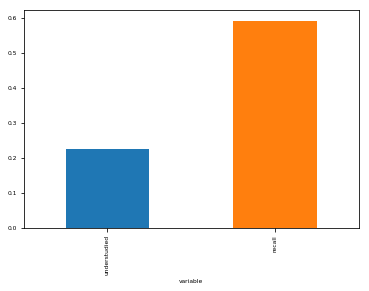

In [71]:
super_anc_df[super_anc_df.cluster_super == 1].set_index('variable')[['value', 'recall']].plot(kind='bar', stacked=True, legend=False)
plt.show()


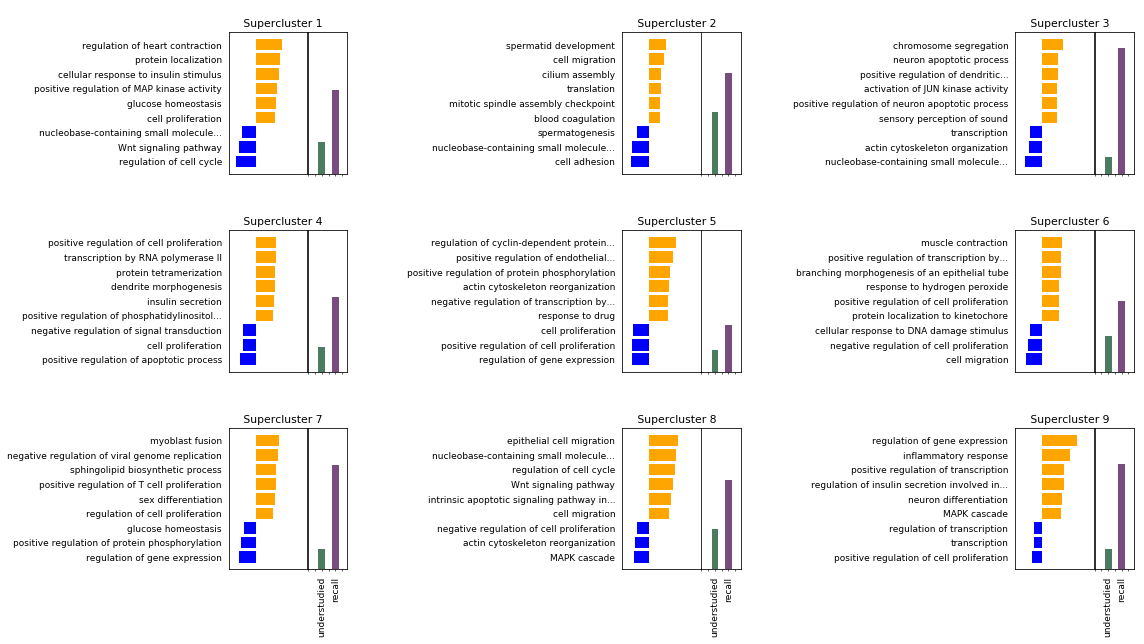

In [73]:
import matplotlib.cm as cm
%matplotlib inline
#sns.set()
plt.rc('font', **{'family':'normal', 'size':9})  
fig, axes = plt.subplots(ncols=12, nrows=3, figsize= (16,8), sharex=True, gridspec_kw={'width_ratios':[25,10,.1,5,35,10,.1,5,35,10,.1,5]})
plt.tight_layout()
plt.subplots_adjust(wspace=0.)
plt.subplots_adjust(hspace=.4)

blank_ax = [0,2,4,6,8,10]

for i in range(3):
    for j in blank_ax:
        axes[i][j].axis('off')
    
plot_idx_list = [1,5,9]*3
count = 0
    
ax_list = []
bar_list = []

for sup_ in super_sub_dict.keys():
    plot_idx = plot_idx_list.pop(0)
    f_importances(coef=np.mean(lh.get_svm_coeffs_for_cluster(louv_slim_super_characterizers[0], sup_-1), axis=0), names=slim_feat, ax=axes[count // 3][plot_idx], top=6, bot=3)
    axes[count // 3][plot_idx].set_title('\n         Supercluster '+str(sup_))
    
    axes[count // 3][plot_idx].xaxis.set_visible(False)
    
    # barplot
    super_anc_df[super_anc_df.cluster_super == sup_].set_index('variable')[['value', 'recall']].rename_axis('').plot(kind='bar', stacked=True,  ax = axes[count // 3][plot_idx+2], legend=False, colormap=cm.PRGn_r, alpha=.7)
    axes[count // 3][plot_idx+2].yaxis.set_visible(False)
    
    ax_list += [(count // 3, plot_idx)]
    bar_list += [(count // 3, plot_idx+2)]
    
    axes[count // 3][plot_idx].tick_params(axis='both', bottom=False, top=False, left=False)
    axes[count // 3][plot_idx+2].tick_params(axis='both', bottom=False, top=False, left=False)

    count+=1    
    
axes[ax_list[0]].get_shared_x_axes().join(*[axes[a] for a in ax_list])
axes[bar_list[0]].get_shared_y_axes().join(*[axes[b] for b in bar_list])

axes[ax_list[0]].set_xlim(-1,1.9)
axes[bar_list[0]].set_ylim(0,1)

plt.savefig('../results/images/supercluster_characterization_PIR_PAF_SLIM_GO_mean.pdf')
#plt.savefig('../viz/images/png/supercluster_characterization_PIR_PAF_SLIM_GO_mean.png')
plt.show()

### Cluster Comparison

In [74]:
louv_sup = louv['cluster_super']
#spin = spinglass_clusters.set_index('names').drop('GO Labels', axis=1)
fast = pd.read_csv(cluster_dir+fastgreedy_file, sep='\t',index_col=0)['cluster']

Below is the fast_greedy membership of each c_spinglass cluster

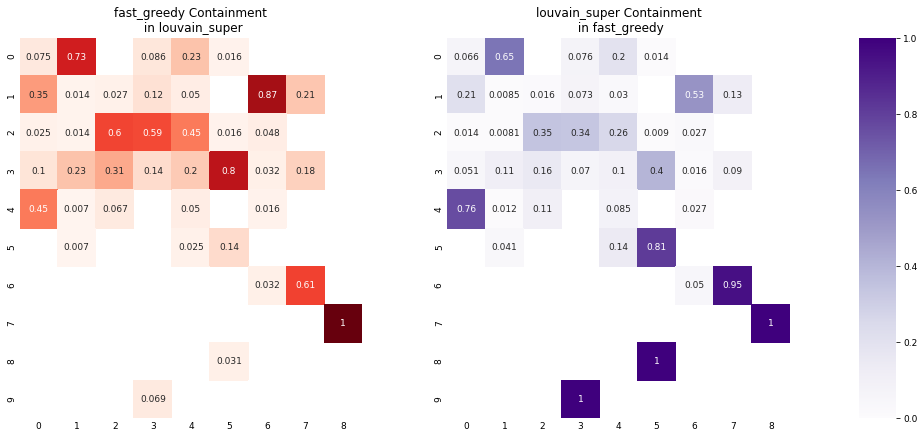

In [75]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

fig, axes = plt.subplots(ncols=3, figsize=(16,7), sharey=False, gridspec_kw={'width_ratios':[10,10,1]})

# fast_greedy membership of louv
cont_mat = pd.DataFrame(contingency_matrix(fast, louv_sup))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)
cont_mat_mask = cont_mat.values == 0

axes[0].set_title('fast_greedy Containment\n in louvain_super', size=12)
axes[0].tick_params(axis='both', length=0)
sns.heatmap(cont_mat, ax=axes[0], cmap='Reds', cbar=False, square=True, annot=True, mask=cont_mat_mask)

# louv membership of fast_greedy
cont_mat_rev = pd.DataFrame(contingency_matrix(fast, louv_sup))
cont_mat_rev = cont_mat.divide(other = cont_mat.sum(axis=1),axis = 0)
cont_mat_rev_mask = cont_mat_rev.values == 0

axes[1].set_title('louvain_super Containment\n in fast_greedy', size=12)
axes[1].tick_params(axis='both', length=0)
sns.heatmap(cont_mat_rev, ax=axes[1], cmap='Purples', cbar_ax=axes[2], square=True, annot=True, mask=cont_mat_rev_mask)

plt.savefig('../results/images/louv_fast_compare.pdf')
#plt.savefig('../viz/images/png/louv_fast_compare.png')

plt.show()

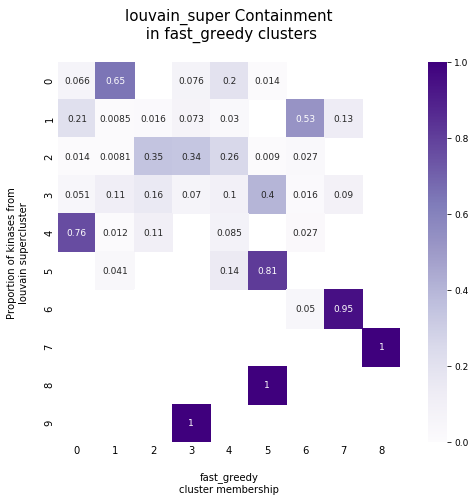

In [76]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))

plt.rc('font', **{'family':'normal', 'size':9})    
ax.set_title('louvain_super Containment\n in fast_greedy clusters\n', size=15)
ax.tick_params(axis='both', length=0)

sns.heatmap(cont_mat_rev, ax=ax, cmap='Purples',square=True, annot=True, mask=cont_mat_rev_mask)
plt.xlabel('\nfast_greedy\ncluster membership')
plt.ylabel('Proportion of kinases from\nlouvain supercluster\n')

plt.savefig('../results/images/louvain_in_fast_greedy.pdf')
#plt.savefig('../viz/images/png/louvain_in_fast_greedy.png')
plt.show()

Below is the louvain membership of each fast_greedy cluster

Rand correlation matrix

In [77]:
clusts = {}
for method in method_list:
    cl = composite_data_dict[method]['go']
    clusts[method] = np.squeeze(cl.drop(['GO Labels'], axis=1).values)

In [ ]:
from sklearn.metrics import adjusted_rand_score as rand
rand_corr_matrix = np.zeros((len(clusts), len(clusts)))

fig, ax = plt.subplots(figsize=(15,12))

for i in range(len(clusts)):
    for j in range(len(clusts)):
        rand_corr_matrix[i,j] = rand(clusts[method_list[i]], clusts[method_list[j]])

mask = np.zeros_like(rand_corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
        
ax.tick_params(axis='both', length=0)
ax.set_title('Adj Rand Scores\nacross clusterings')
sns.heatmap(rand_corr_matrix,mask=mask,cmap='viridis', square=True, vmax=.85, cbar_kws={"shrink": .9}, linewidths=0.01, xticklabels=method_list,yticklabels=method_list, ax = ax, annot=True)
print(plt.yticks())
plt.yticks([0.25, 1.2, 2.39, 3.25, 4.24, 5.08, 6.1, 7.26, 8.02])

plt.savefig('../results/images/adj_rand_scores.pdf')
#plt.savefig('../viz/images/png/adj_rand_scores.png')
plt.show()